# Risk Model with ML

In [31]:
#### Imports ####
#################

### basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy
from pickle import dump
from pickle import load


### skleaern
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

### others

import statsmodels.api as sm


#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
#### Functions ####

def dta2csv(fname_in,fname_out):
    data = pd.io.stata.read_stata(fname_in)
    data.to_csv(fname_out)
    dataset = pd.read_csv(fname_out)
    return dataset 

## Loading the Data

In [4]:
# load dataset
dataset = dta2csv('data/Base imputada EFH 2021.dta','data/my_stata_file2021.csv')
dataset.head()

,Unnamed: 0,imp,id,factor,genero_ent,edad_ent,tr_edad_ent,nacionalidad_ent,educ_ent,neduc_ent,...,u_tnbco,u_prepago,u_cheq,u_pat,u_transf,u_bip,u_tcripto,u_pel,u_tprepago,u_pac
0,0,0.0,10002.0,2356.0,Mujer,37,entre 35 y 49,Chileno(a),12.0,Ed. Básica,...,No,No,No,No,Si,No,No,Si,No,No
1,1,0.0,10003.0,1232.0,Hombre,76,igual o mayor a 65,Chileno(a),12.0,Ed. Básica,...,No,Si,No,Si,No,No,No,Si,No,No
2,2,0.0,10004.0,1927.0,Hombre,69,igual o mayor a 65,Chileno(a),6.0,Ed. diferencial,...,No,No,No,No,Si,No,No,No,No,No
3,3,0.0,10005.0,2573.0,Mujer,45,entre 35 y 49,Chileno(a),12.0,Ed. Básica,...,No,No,No,No,Si,Si,No,Si,No,No
4,4,0.0,10006.0,1796.0,Hombre,60,entre 50 y 64,Peruano(a),9.0,Ed. Básica,...,No,No,No,No,No,Si,No,No,Si,No


## DATA 2 Values

### Education Level

In [5]:
dataset.loc[dataset["neduc_ent"] == "Sin educación", "neduc_ent"] = 0.0
dataset.loc[dataset["neduc_ent"] == "Ed. diferencial", "neduc_ent"] = 1.0
dataset.loc[dataset["neduc_ent"] == "Ed. Básica", "neduc_ent"] = 2.0
dataset.loc[dataset["neduc_ent"] == "Ed. Media", "neduc_ent"] = 3.0
dataset.loc[dataset["neduc_ent"] == "CFT o IP", "neduc_ent"] = 4.0
dataset.loc[dataset["neduc_ent"] == "Universitaria", "neduc_ent"] = 5.0
dataset.loc[dataset["neduc_ent"] == "Postgrado", "neduc_ent"] = 6.0

### Family number

In [6]:
dataset.loc[dataset["tr_numh"] == "7 o más personas en el hogar", "tr_numh"] = 4.0
dataset.loc[dataset["tr_numh"] == "entre 1 y 2 personas en el hogar", "tr_numh"] = 1.0
dataset.loc[dataset["tr_numh"] == "entre 3 y 4 personas en el hogar", "tr_numh"] = 2.0
dataset.loc[dataset["tr_numh"] == "entre 5 y 6 personas en el hogar", "tr_numh"] = 3.0
dataset.loc[dataset["tr_numh"] == "más de 6 personas en el hogar", "tr_numh"] = 4.0

### Civil Status


In [7]:

dataset.loc[dataset["est_civil_ent"] == "Casado(a)", "est_civil_ent"] = 1.0
dataset.loc[dataset["est_civil_ent"] == "Conviviente o pareja", "est_civil_ent"] = 2.0
dataset.loc[dataset["est_civil_ent"] == "Conviviente o pareja sin acuerdo de unión civil", "est_civil_ent"] = 2.0
dataset.loc[dataset["est_civil_ent"] == "Conviviente civil (con acuerdo)", "est_civil_ent"] = 2.0
dataset.loc[dataset["est_civil_ent"] == "Anulado", "est_civil_ent"] = 3.0
dataset.loc[dataset["est_civil_ent"] == "Anulado(a)", "est_civil_ent"] = 3.0
dataset.loc[dataset["est_civil_ent"] == "Separado(a)", "est_civil_ent"] = 4.0
dataset.loc[dataset["est_civil_ent"] == "Separado(a) de union de hecho", "est_civil_ent"] = 4.0
dataset.loc[dataset["est_civil_ent"] == "Separado(a) de union legal", "est_civil_ent"] = 4.0
dataset.loc[dataset["est_civil_ent"] == "Viudo(a)", "est_civil_ent"] = 5.0
dataset.loc[dataset["est_civil_ent"] == "Soltero(a)", "est_civil_ent"] = 6.0
dataset.loc[dataset["est_civil_ent"] == "Divorciado(a)", "est_civil_ent"] = 7.0

### Occupied or not

In [8]:
dataset.loc[dataset["ocup_ent"] == "Desocupado", "ocup_ent"] = 0.0
dataset.loc[dataset["ocup_ent"] == "Ocupado", "ocup_ent"] = 1.0

### Economic Stratus

In [9]:
dataset['estrato'] = dataset['estrato'].map(lambda x: int(x.split("Deciles")[1].split("al")[0]))

### Adding Risk Features

Compute the Risky asset and the riskless assets for all the individuals in the survey data. Risky and riskless assets are defined as follows:
Risky assets is investments in mutual funds, stocks, bonds, commodities, and real estate, and an estimate of human capital.
Risk Free Assets: checking and savings balances,certificates of deposit, and other cash balances and equivalents.

According to the glossary: risky = act_var, risk free= act_fijo + act_ahcta . (we could to these add the category of "activos reales" ?? the quantity "ahorros" = t_habah, habah_m and habah_f should definetely be part of the learning, this is an indication of how the family raises money)

the value equivalent to KIDS is in my opion "numh", AGE is "edad_pr", EDUC is "neduc_pr" (we take "educ_pr" as this is a number) , married is "est_civil_pr", OCCU is "ocup_pr", INCOME is "estrato", NETWORTH is "act_toth", RISK isnt really there. 

In [10]:
#### Filter of trash columns ####

keep_list2 = ['estrato','rci_dt','tr_numh','edad_ent','neduc_ent','est_civil_ent','ocup_ent','act_ahcta','act_fin','act_finvar','act_finfija','act_toth']
drop_list2 = [col for col in dataset.columns if col not in keep_list2]
dataset.drop(labels=drop_list2, axis=1, inplace=True)

In [11]:
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt
0,37,2.0,1.0,1.0,6,3.0,2160000.0,0.0,NaN,0.655405
1,76,2.0,1.0,0.0,1,1.0,NaN,0.0,NaN,0.000000
2,69,1.0,1.0,0.0,1,2.0,0.0,0.0,62000000.0,0.000000
3,45,2.0,1.0,1.0,6,3.0,0.0,0.0,92500000.0,0.000000
4,60,2.0,6.0,1.0,1,3.0,0.0,0.0,80000000.0,0.000000


## Removing Nulls

In [12]:
# Drop the rows containing NA
dataset=dataset.dropna(axis=0)

dataset=dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [13]:
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt
2,69,1.0,1.0,0.0,1,2.0,0.0,0.0,62000000.0,0.000000
3,45,2.0,1.0,1.0,6,3.0,0.0,0.0,92500000.0,0.000000
4,60,2.0,6.0,1.0,1,3.0,0.0,0.0,80000000.0,0.000000
5,74,1.0,6.0,0.0,1,1.0,0.0,90000.0,165540000.0,0.074697
6,65,1.0,4.0,0.0,1,1.0,0.0,0.0,40000000.0,0.000000


### Adding Risk Tolerance 

In [14]:

#Risk Tolerance 

#USAR ESTO PARA DATOS DE 2017 dataset['act_fin'] = dataset['act_finvar']+dataset['act_finfija']
dataset['RT'] = dataset['act_fin']/(dataset['act_ahcta']+dataset['act_fin'])
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt,RT
2,69,1.0,1.0,0.0,1,2.0,0.0,0.0,62000000.0,0.000000,NaN
3,45,2.0,1.0,1.0,6,3.0,0.0,0.0,92500000.0,0.000000,NaN
4,60,2.0,6.0,1.0,1,3.0,0.0,0.0,80000000.0,0.000000,NaN
5,74,1.0,6.0,0.0,1,1.0,0.0,90000.0,165540000.0,0.074697,0.0
6,65,1.0,4.0,0.0,1,1.0,0.0,0.0,40000000.0,0.000000,NaN


### New filtering 

In [15]:
dataset = dataset[dataset['act_ahcta'] > 100000]  
dataset = dataset[dataset['rci_dt'] > 0] 

In [16]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [17]:
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt,RT
7,43,4.0,1.0,1.0,9,3.0,600000.0,30000000.0,3.456273e+08,0.249307,0.019608
17,50,4.0,6.0,1.0,9,2.0,3000000.0,400000.0,3.034000e+08,2.686299,0.882353
21,37,4.0,4.0,1.0,6,2.0,0.0,9000000.0,8.400000e+07,0.171058,0.000000
23,53,3.0,2.0,1.0,9,1.0,31000000.0,3000000.0,1.943485e+08,0.182609,0.911765
29,37,4.0,1.0,1.0,9,2.0,4600000.0,500000.0,1.269440e+08,0.059524,0.901961


In [19]:
datasetoriginal=dataset.copy() ### Backup

### Dataset 2 work with

In [20]:
dataset = dataset.reset_index()
dataset = dataset.drop(columns=['index'])
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt,RT
0,43,4.0,1.0,1.0,9,3.0,600000.0,30000000.0,3.456273e+08,0.249307,0.019608
1,50,4.0,6.0,1.0,9,2.0,3000000.0,400000.0,3.034000e+08,2.686299,0.882353
2,37,4.0,4.0,1.0,6,2.0,0.0,9000000.0,8.400000e+07,0.171058,0.000000
3,53,3.0,2.0,1.0,9,1.0,31000000.0,3000000.0,1.943485e+08,0.182609,0.911765
4,37,4.0,1.0,1.0,9,2.0,4600000.0,500000.0,1.269440e+08,0.059524,0.901961


In [32]:
dataset['neduc_ent'] =dataset['neduc_ent'].astype(float)
dataset['est_civil_ent'] =dataset['est_civil_ent'].astype(float)
dataset['ocup_ent'] =dataset['ocup_ent'].astype(float)
dataset['tr_numh'] =dataset['tr_numh'].astype(float)

## Exploratory Data Analysis

### Correlation

<AxesSubplot: title={'center': 'Correlation Matrix'}>

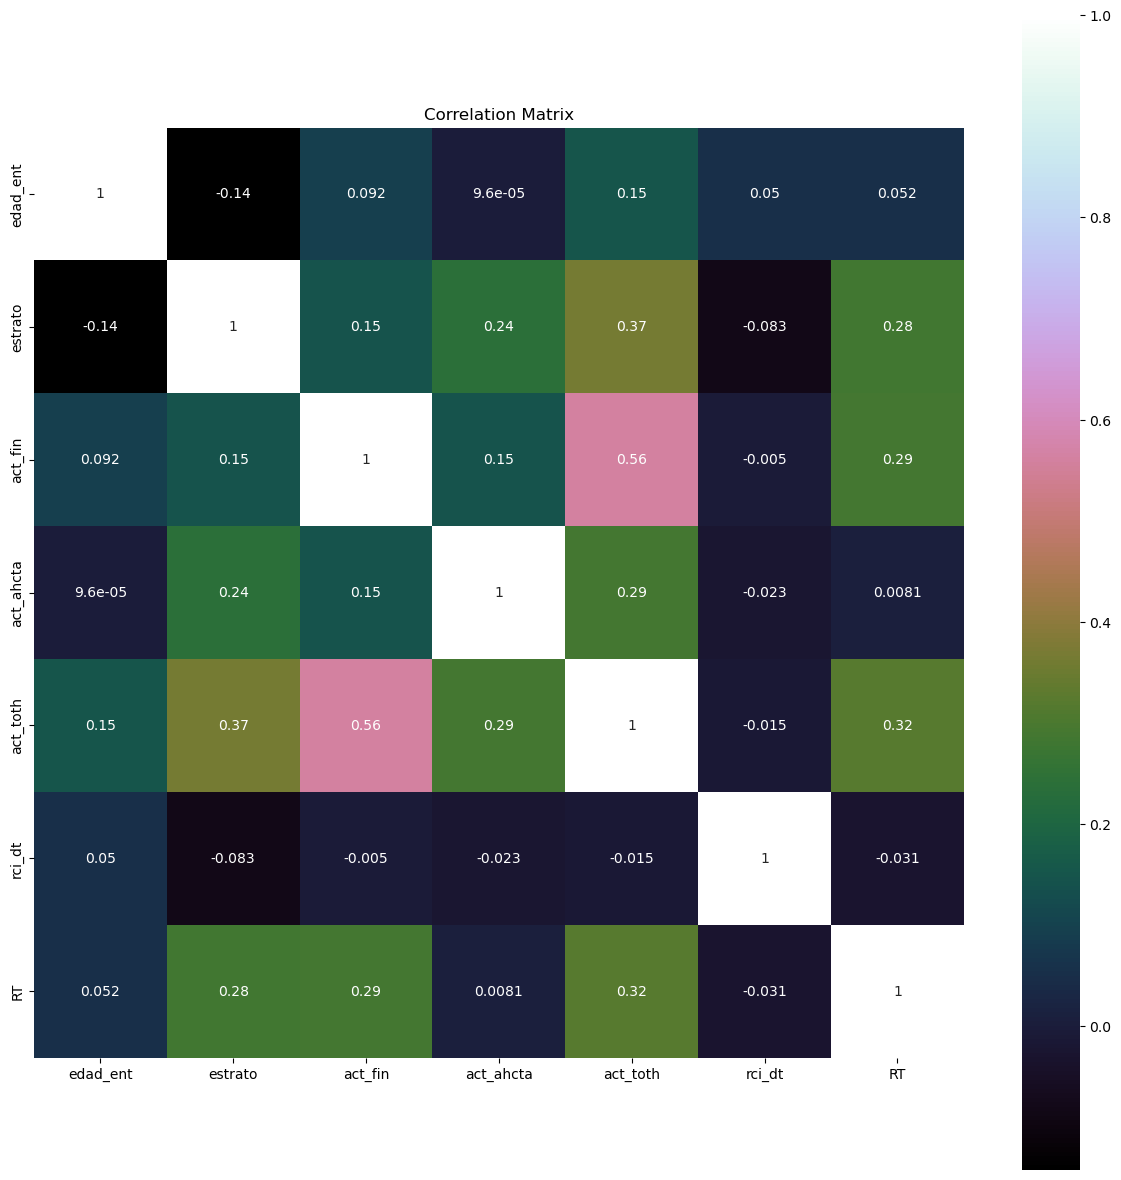

In [21]:
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [37]:
correlation

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt,RT
edad_ent,1.000000,-0.142153,-0.181975,-0.223472,-0.083350,-0.149457,0.138714,0.002240,0.223200,0.029651,0.177829
neduc_ent,-0.142153,1.000000,0.004558,0.158232,0.325602,-0.044643,0.097925,0.045461,0.244043,0.039678,0.052282
est_civil_ent,-0.181975,0.004558,1.000000,0.005012,-0.249912,-0.276761,-0.113904,-0.112357,-0.245508,0.082794,-0.015407
ocup_ent,-0.223472,0.158232,0.005012,1.000000,0.335813,0.016111,0.024224,0.084995,0.067768,-0.114990,0.012099
estrato,-0.083350,0.325602,-0.249912,0.335813,1.000000,0.182180,0.147807,0.210674,0.336357,-0.177965,0.107838
tr_numh,-0.149457,-0.044643,-0.276761,0.016111,0.182180,1.000000,-0.028548,-0.003873,0.111738,-0.069598,0.006845
act_fin,0.138714,0.097925,-0.113904,0.024224,0.147807,-0.028548,1.000000,0.143836,0.594953,0.007903,0.239448
act_ahcta,0.002240,0.045461,-0.112357,0.084995,0.210674,-0.003873,0.143836,1.000000,0.271458,-0.039699,-0.223922
act_toth,0.223200,0.244043,-0.245508,0.067768,0.336357,0.111738,0.594953,0.271458,1.000000,0.021543,0.200284
rci_dt,0.029651,0.039678,0.082794,-0.114990,-0.177965,-0.069598,0.007903,-0.039699,0.021543,1.000000,-0.017901


## Train/Test split

In [22]:
Y= dataset['RT']
X = dataset.loc[:, dataset.columns != 'RT']
X = X.loc[:, X.columns != 'act_ahcta']
X = X.loc[:, X.columns != 'act_fin']
X = X.loc[:, X.columns != 'act_finvar']
X = X.loc[:, X.columns != 'act_finfija']
X = X.loc[:, X.columns != 'rci_dt']
X = X.loc[:, X.columns != 'estrato']

In [23]:
X.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,tr_numh,act_toth
0,43,4.0,1.0,1.0,3.0,3.456273e+08
1,50,4.0,6.0,1.0,2.0,3.034000e+08
2,37,4.0,4.0,1.0,2.0,8.400000e+07
3,53,3.0,2.0,1.0,1.0,1.943485e+08
4,37,4.0,1.0,1.0,2.0,1.269440e+08


In [24]:
X.count()

edad_ent         23755
neduc_ent        23755
est_civil_ent    23755
ocup_ent         23755
tr_numh          23755
act_toth         23755
dtype: int64

In [25]:
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Models

In [26]:
# test options for regression
num_folds = 10
#scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
scoring = 'r2'

In [27]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
#models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
#models.append(('MLP', MLPRegressor()))
#Ensable Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [28]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.131048 (0.007574)
LASSO: 0.103288 (0.007056)
EN: 0.103288 (0.007056)
KNN: 0.810771 (0.018788)
SVR: 0.074942 (0.017592)
ABR: 0.182292 (0.012407)
GBR: 0.399687 (0.014744)
RFR: 0.963750 (0.006156)
ETR: 0.967651 (0.006473)


### Obs
We find that the best models are RandomForest and Extra Tree Regressors

### HyperTuning RFR

In [29]:
'''
n_estimators : integer, optional (default=10)
        The number of trees in the forest.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, \
      cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.964187 using {'n_estimators': 100}


In [35]:
### Final model
model = models[7][1].fit(X_train, Y_train)

### Check final model error

In [36]:
y_predict = model.predict(X_validation)
print(r2_score(Y_validation,y_predict))

0.9657021454566015


## Export

In [37]:
with open("model/risk_model_2.p","wb") as f:
    dump(model,f)